In [ ]:
# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import scipy.io

## Pre-Processing

#### Deleting Wav File to Save Space and Combine Folders Across Days

In [ ]:
train_bird = "/home/george-vengrovski/Documents/canary_song_detector/USA5207"
test_bird =  "/home/george-vengrovski/Documents/canary_song_detector/USA5199"

if os.path.exists(train_bird + "/joined_trained") == False:
    os.mkdir(train_bird + "/joined_trained")
if os.path.exists(test_bird + "/joined_test") == False:
    os.mkdir(test_bird + "/joined_test")

train_folders = os.listdir(train_bird)
test_folders = os.listdir(test_bird)


dst_trained = train_bird + "/joined_trained"
dst_test = test_bird + "/joined_test"

for folder in train_folders:
    if folder == "joined_trained":
        continue 

    files = os.listdir(os.path.join(train_bird, folder))
    
    for file in files:
        if file.endswith('.wav'):
            os.remove(os.path.join(train_bird, folder, file))
        else:
            for matrix in os.listdir(os.path.join(train_bird, folder, file)):
                src = os.path.join(train_bird, folder, file, matrix)
                shutil.copy(src, dst_trained)

for folder in test_folders:
    if folder == "joined_test":
        continue 

    files = os.listdir(os.path.join(test_bird, folder))
    
    for file in files:
        if file.endswith('.wav'):
            os.remove(os.path.join(test_bird, folder, file))
        else:
            for matrix in os.listdir(os.path.join(test_bird, folder, file)):
                src = os.path.join(test_bird, folder, file, matrix)
                shutil.copy(src, dst_test)

#### Test and Train Split

In [ ]:
split = 0.8
true_root_dir = "/home/george-vengrovski/Documents/canary_song_detector"
train_dir = os.path.join(true_root_dir, "train/")
test_dir = os.path.join(true_root_dir, "test/")

shutil.copytree(dst_trained, train_dir)
shutil.copytree(dst_test, test_dir)

#### Dataloader

In [ ]:
class DetectorDataClass():
    def __init__(self, dir, spec=513):
        self.data = []
        self.spec = spec

        for file in os.listdir(dir):
            self.data.append(os.path.join(dir, file))

    def __getitem__(self, index):
        data = self.data[index]
        mat_data = scipy.io.loadmat(data)
        mat_data = mat_data["song_data"]
        mat_data = mat_data[0][0]

        arr1 = mat_data[0]
        arr2 = mat_data[1]

        # beware if spec shape changes, this might cause error
        if arr1.shape[0] == self.spec:
            spec = torch.Tensor(arr1)
            raw_labels = torch.Tensor(arr2).int()
        else:
            spec = torch.Tensor(arr2)
            raw_labels = torch.Tensor(arr1).int()

        if raw_labels.shape == (0,0):
            song = False
        else:
            song = True

        # labels will be the same length as the song, but it will be filled with 1s between indcies of start and stops
        labels = torch.zeros(size=(spec.shape[1],))
        if song == True:
            num_entries = raw_labels.shape[0]
            for i in range(num_entries):
                if i % 2 == 0:
                    labels[raw_labels[i]:raw_labels[i+1]].fill_(1)
        
        spec = spec.unsqueeze(0)
        
        return spec, labels, song

    def __len__(self):
        return len(self.data) 

def collate_fn(batch):
    # Extract sequences and labels
    sequences = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    
    # Find the max length for padding
    max_len_spec = max([s.size(2) for s in sequences])
    max_len_labels = max([l.size(0) for l in labels])
    
    # Pad each sequence to max length
    sequences_padded = []
    for s in sequences:
        pad_size = max_len_spec - s.size(2)
        sequences_padded.append(F.pad(s, (0, pad_size)))
    
    # Pad each label to max length
    labels_padded = []
    for l in labels:
        pad_size = max_len_labels - l.size(0)
        labels_padded.append(F.pad(l, (0, pad_size)))
    
    # Convert lists to tensors
    sequences_padded = torch.stack(sequences_padded)
    labels_padded = torch.stack(labels_padded)
    
    # Get the song flags
    songs = [x[2] for x in batch]
    songs = torch.Tensor(songs)
    
    return sequences_padded, labels_padded, songs

train_dir = "/home/george-vengrovski/Documents/canary_song_detector/train"
test_dir = "/home/george-vengrovski/Documents/canary_song_detector/test"

train_dataset = DetectorDataClass(train_dir)
test_dataset = DetectorDataClass(test_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [355]:
class aviaBERT(nn.Module):
    def __init__(self, d_transformer, nhead_transformer, embedding_dim, num_labels, tau=0.1, dropout=0.1, transformer_layers=1,dim_feedforward=32):
        super(aviaBERT, self).__init__()
        self.tau = tau
        self.num_labels = num_labels
        self.dropout = dropout

        # TweetyNet Front End
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5), stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))

        # Positional Encoding
        self.pos_conv1 = nn.Conv1d(d_transformer, d_transformer, kernel_size=3, padding=1, dilation=1)
        self.pos_conv2 = nn.Conv1d(d_transformer, d_transformer, kernel_size=3, padding=2, dilation=2)

        # transformer
        self.transformerProjection = nn.Linear(512, d_transformer)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_transformer, nhead=nhead_transformer, batch_first=True, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=transformer_layers)
        self.transformerDeProjection = nn.Linear(d_transformer, embedding_dim)
        self.onedconv = nn.Conv1d(embedding_dim, 1, kernel_size=31, stride=1, padding=15)

    def convolutional_positional_encoding(self, x):
        pos = F.relu(self.pos_conv1(x))
        pos = F.relu(self.pos_conv2(pos))
        return pos

    def feature_extractor_forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(1,2)
        return x

    def transformer_forward(self, x):
        # project the input to the transformer dimension
        x = x.permute(0,2,1)
        x = self.transformerProjection(x)
        x = x.permute(0,2,1)

        # add convolutional positional encoding
        pos_enc = self.convolutional_positional_encoding(x)
        x = x + pos_enc
        x = x.permute(0,2,1)
        x = self.transformer_encoder(x)
        x = self.transformerDeProjection(x)
        return x

    def forward(self, x):
        x = self.feature_extractor_forward(x)
        x = self.transformer_forward(x)
        x = x.permute(0,2,1)
        x = self.onedconv(x)
        x = x.permute(0,2,1)
        return x

    def BCE_loss(self, y_pred, y_true, weights, too_small=50, scaling_factor=.00):
        # Convert y_pred to binary tensor for > 0.5 and < 0.5
        binary_pred_over_half = (y_pred > 0.5).float()
        binary_pred_under_half = (y_pred < 0.5).float()

        # Define a kernel of size too_small with all ones.
        kernel = torch.ones(too_small).to(y_pred.device)

        # Perform 1D convolution for > 0.5.
        conv_result_over_half = F.conv1d(binary_pred_over_half.unsqueeze(1), kernel.view(1,1,-1), padding=too_small-1).squeeze(1)
        
        # Perform 1D convolution for < 0.5.
        conv_result_under_half = F.conv1d(binary_pred_under_half.unsqueeze(1), kernel.view(1,1,-1), padding=too_small-1).squeeze(1)

        # A mask for regions of > 0.5 that are not continuous.
        non_continuous_mask_over_half = (conv_result_over_half < too_small) & (conv_result_over_half > 0)

        # A mask for regions of < 0.5 that are not continuous.
        non_continuous_mask_under_half = (conv_result_under_half < too_small) & (conv_result_under_half > 0)

        # Find the actual indices for > 0.5.
        non_continuous_indices_over_half = torch.nonzero(non_continuous_mask_over_half).squeeze()
        non_continuous_indices_over_half = non_continuous_indices_over_half.flatten()
        count_non_continuous_over_half = (non_continuous_indices_over_half > -1).sum().item()
        
        # Find the actual indices for < 0.5.
        non_continuous_indices_under_half = torch.nonzero(non_continuous_mask_under_half).squeeze()
        non_continuous_indices_under_half = non_continuous_indices_under_half.flatten()
        count_non_continuous_under_half = (non_continuous_indices_under_half > -1).sum().item()

        # Expand weights tensor to have the same shape as y_pred
        weights = weights.unsqueeze(dim=1)
        weights = weights.expand(weights.shape[0], y_pred.shape[1]).to(y_pred.device)

        loss_fn = torch.nn.BCEWithLogitsLoss(weight=weights)
        loss = loss_fn(input = y_pred, target = y_true)
        
        # Combine the penalties for regions over and under 0.5
        total_penalty = count_non_continuous_over_half + count_non_continuous_under_half

        return loss * (1 + total_penalty * scaling_factor)

In [356]:
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

def detailed_count_parameters(model):
    """Print details of layers with the number of trainable parameters in the model."""
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
        # print(f"Layer: {name} | Parameters: {param:,} | Shape: {list(parameter.shape)}")
    print(f"\nTotal Trainable Parameters: {total_params:,}")

epochs = 100
learning_rate = 1e-4
balance_weight = 4.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_list = []
model = aviaBERT(d_transformer=8, nhead_transformer=1, embedding_dim=1, num_labels=1, tau=0.1, dropout=0.2)
detailed_count_parameters(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)


Total Trainable Parameters: 58,385


Step [0/10000], Training Loss: 8.34e-01, Validation Loss: 6.67e-01, Frame Error Rate: 4.65%
Step [500/10000], Training Loss: 5.43e-02, Validation Loss: 8.28e-02, Frame Error Rate: 0.82%
Step [1000/10000], Training Loss: 7.18e-02, Validation Loss: 8.31e-02, Frame Error Rate: 0.85%
Step [1500/10000], Training Loss: 1.11e-01, Validation Loss: 4.48e-02, Frame Error Rate: 0.54%
Step [2000/10000], Training Loss: 8.23e-03, Validation Loss: 7.94e-02, Frame Error Rate: 0.76%
Step [2500/10000], Training Loss: 5.13e-04, Validation Loss: 6.61e-02, Frame Error Rate: 0.66%
Step [3000/10000], Training Loss: 9.28e-02, Validation Loss: 7.24e-02, Frame Error Rate: 0.75%
Step [3500/10000], Training Loss: 3.26e-02, Validation Loss: 1.00e-01, Frame Error Rate: 0.90%
Step [4000/10000], Training Loss: 3.14e-02, Validation Loss: 4.15e-02, Frame Error Rate: 0.44%
Step [4500/10000], Training Loss: 6.76e-03, Validation Loss: 4.47e-02, Frame Error Rate: 0.59%
Step [5000/10000], Training Loss: 6.01e-02, Validation

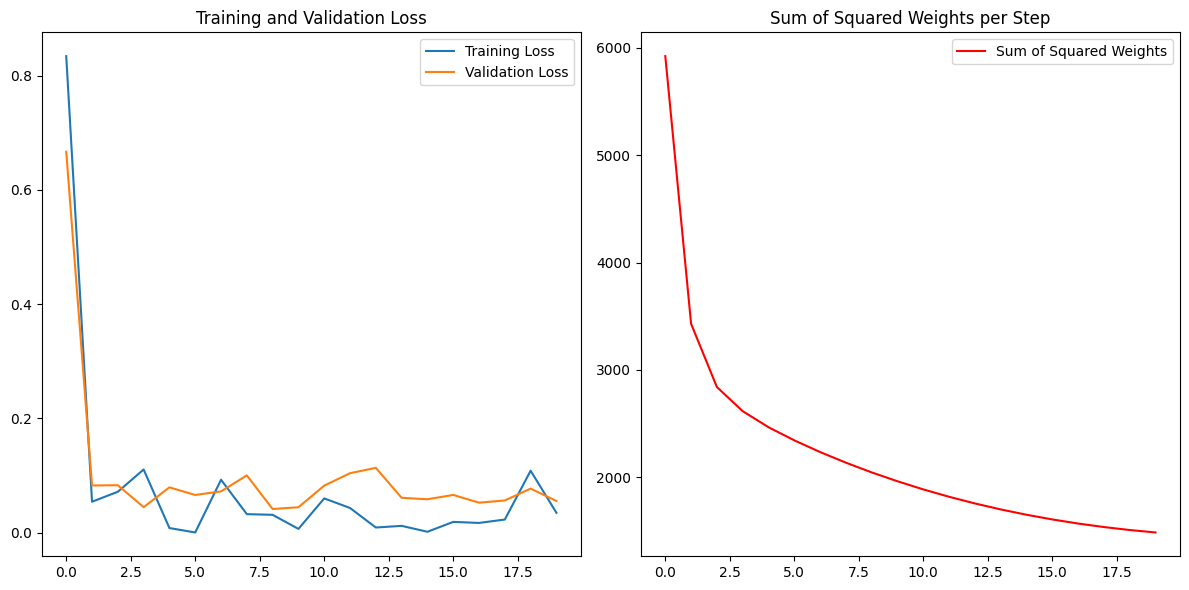

final loss 0.034959010779857635


In [318]:
class ModelTrainer:
    def __init__(self, model, train_loader, test_loader, optimizer, device, max_steps=10000, eval_interval=2000):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.device = device
        self.max_steps = max_steps
        self.eval_interval = eval_interval
        
        self.loss_list = []
        self.val_loss_list = []
        self.sum_squared_weights_list = []

    def sum_squared_weights(self):
        sum_of_squares = sum(torch.sum(p ** 2) for p in self.model.parameters())
        return sum_of_squares

    def frame_error_rate(self, y_pred, y_true):
        y_pred = F.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        mismatches = (y_pred != y_true)
        error = mismatches.sum() / y_true.size(0) / y_true.size(1)
        return error * 100

    def validate_model(self):
        self.model.eval()
        total_val_loss = 0
        total_frame_error = 0
        num_val_batches = 0
        with torch.no_grad():
            for i, (spec, label, song) in enumerate(self.test_loader):
                if i > 100:
                    break
                spec = spec.to(self.device)
                label = label.to(self.device)

                output = self.model.forward(spec)
                weights = torch.ones(size=(song.shape[0],), requires_grad=True).to(self.device)
                weights = torch.where(song == True, 4.0, 1.0)
                loss = self.model.BCE_loss(y_pred = output.squeeze(2), y_true=label, weights=weights)

                total_frame_error += self.frame_error_rate(y_pred = output.squeeze(2), y_true=label).item()
                total_val_loss += loss.item()
                num_val_batches += 1

        return total_val_loss / num_val_batches, total_frame_error / num_val_batches

    def train(self):
        step = 0
        train_iter = iter(self.train_loader)
        while step < self.max_steps:
            try:
                spec, label, song = next(train_iter)
            except StopIteration:
                train_iter = iter(self.train_loader)
                spec, label, song = next(train_iter)

            spec = spec.to(self.device)
            label = label.to(self.device)

            output = self.model.forward(spec)
            weights = torch.ones(size=(song.shape[0],), requires_grad=True).to(self.device)
            weights = torch.where(song == True, 4.0, 1.0)
            loss = self.model.BCE_loss(y_pred = output.squeeze(2), y_true=label, weights=weights)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if step % self.eval_interval == 0:
                avg_val_loss, avg_frame_error = self.validate_model()
                self.val_loss_list.append(avg_val_loss)
                self.loss_list.append(loss.item())
                self.sum_squared_weights_list.append(self.sum_squared_weights().item())
                print(f'Step [{step}/{self.max_steps}], Training Loss: {loss.item():.2e}, Validation Loss: {avg_val_loss:.2e}, Frame Error Rate: {avg_frame_error:.2f}%')

            step += 1

    def plot_results(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.loss_list, label='Training Loss')
        plt.plot(self.val_loss_list, label='Validation Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.subplot(1, 2, 2)
        plt.plot(self.sum_squared_weights_list, color='red', label='Sum of Squared Weights')
        plt.legend()
        plt.title('Sum of Squared Weights per Step')

        plt.tight_layout()
        plt.show()

# Usage:
trainer = ModelTrainer(model, train_loader, test_loader, optimizer, device, max_steps=10000, eval_interval=2000)
trainer.train()
trainer.plot_results()
print(f"final loss {trainer.loss_list[-1]}")

tensor(0.)


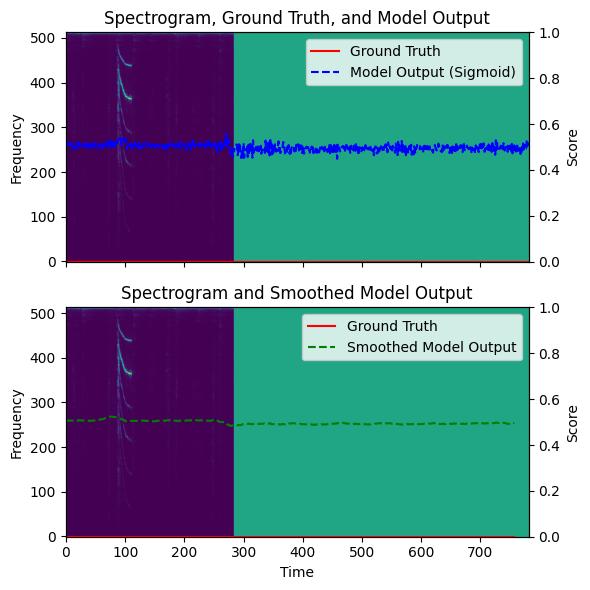

In [362]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

spec, labels, song = next(iter(test_loader))
output = model(spec.to(device))

# Apply the sigmoid function to the model's output
sigmoid_output = F.sigmoid(output[0]).detach().cpu().numpy()
sigmoid_output = sigmoid_output.squeeze()

# Smooth the sigmoid output
window_size = 25  # You can adjust this value
smoothed_output = moving_average(sigmoid_output, window_size)

# Print the song name or details
print(song[0])

# Create a figure and axis for the spectrogram
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# --- First plot with original outputs ---
# Plot the spectrogram
ax1.imshow(spec[0, 0], aspect='auto', origin='lower', cmap='viridis')
ax1.set_ylabel('Frequency')
ax1.set_title('Spectrogram, Ground Truth, and Model Output')

ax2 = ax1.twinx()
ax2.set_ylim([0, 1])
ax2.plot(labels[0], color='red', label='Ground Truth')
ax2.plot(sigmoid_output, color='blue', linestyle='dashed', label='Model Output (Sigmoid)')
ax2.set_ylabel('Score')
ax2.legend(loc='upper right')

# --- Second plot with smoothed outputs ---
ax3.imshow(spec[0, 0], aspect='auto', origin='lower', cmap='viridis')
ax3.set_xlabel('Time')
ax3.set_ylabel('Frequency')
ax3.set_title('Spectrogram and Smoothed Model Output')

ax4 = ax3.twinx()
ax4.set_ylim([0, 1])
ax4.plot(labels[0][window_size-1:], color='red', label='Ground Truth')
ax4.plot(smoothed_output, color='green', linestyle='dashed', label='Smoothed Model Output')
ax4.set_ylabel('Score')
ax4.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


In [317]:
torch.save(model.state_dict(), 'model_weights.pth')